#### Find best $N_0$ 
Compute coherent cross section for fixed $N_0$, calculate $\chi^2$.

In [1]:
import Pkg
Pkg.activate("/Users/dana/Work/protonshape")

  Activating project at `~/Work/protonshape`


In [2]:
include("../src/ProtonShape.jl")
using .ProtonShape

In [3]:
include("../src/plotrecipes.jl")
include("../src/data.jl")

read_coherent_data (generic function with 1 method)

In [4]:
params_run_local = (run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "testnorm/")

(run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "testnorm/")

In [ ]:
diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc; p_shape=params_shape, p_run=params_run_local)

In [5]:
Δ_range = range(params_mc.Δmin, stop=params_mc.Δmax, length=params_mc.Δlen)
Nsamples = params_shape.Nsamples
t_range, dσdt_coh, dσdt_coh_err, dσdt_incoh, dσdt_incoh_err = compute_cross_sections("../results/testnorm", Δ_range, Nsamples, params_run_local, Nsamples)

Computed cross sections for path: ../results/testnorm


([0.0, 0.0625, 0.25, 0.5625, 1.0], [197.120678277359, 148.9208790820196, 64.22201031849774, 15.506012746217742, 2.185804549883983], [0.6717482372652779, 0.48455941114338175, 0.309885303801215, 0.23554906449414373, 0.0879072116047418], [0.0022891849713293486, 0.0015766615425513732, 0.0014952646457877528, 0.0035781836821778823, 0.0035353928842958575], [0.6709524913149265, 0.4252216591628353, 0.22096038618109617, 0.18012984634951948, 0.07979999940940732])

In [6]:
tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")
tcent_incoh_hera, dσdt_incoh_hera, Δtot_incoh_hera = read_coherent_data("../data/jpsi_incoh_hera.txt")

([0.1, 0.29, 0.52, 0.78, 1.12, 1.55, 2.21, 3.3, 5.71], [47.3, 43.8, 36.7, 27.8, 16.8, 10.05, 6.04, 2.8, 0.875], [6.7, 6.0, 5.1, 4.2, 2.59, 1.56, 0.68, 0.38, 0.178])

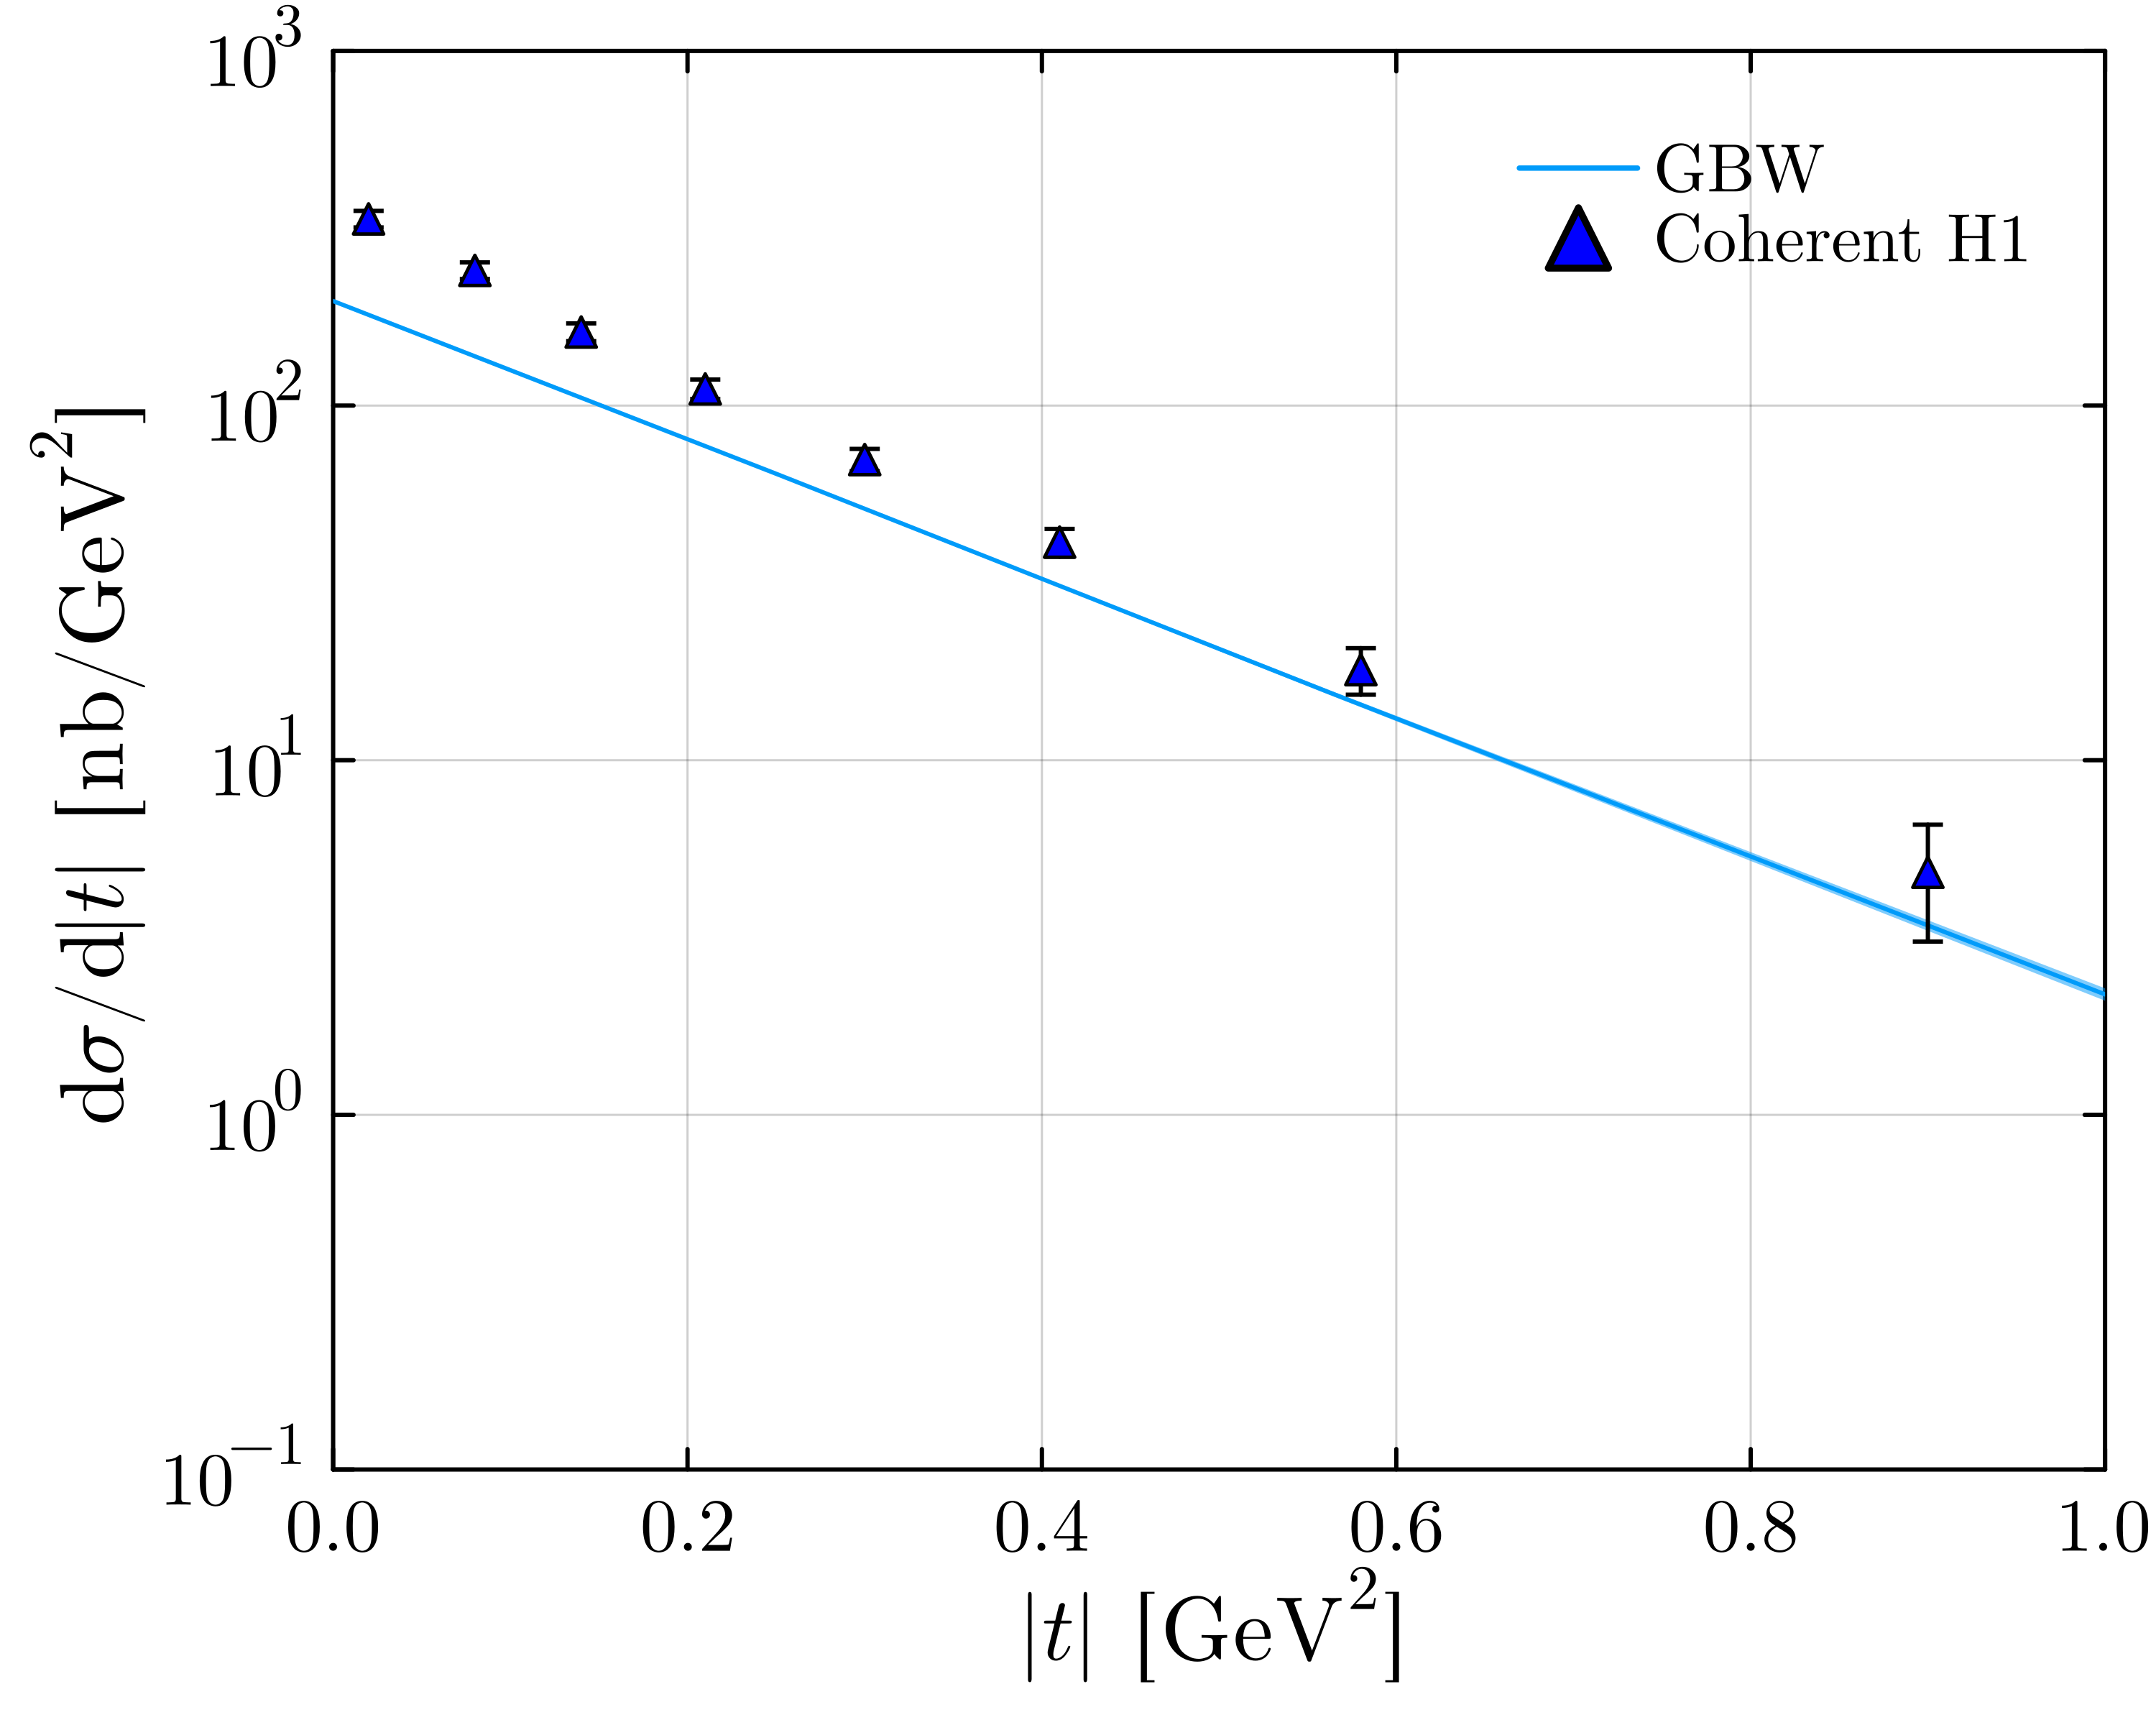

In [7]:
data = CoherentMCData(t_range, dσdt_coh, dσdt_coh_err, tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera)
p = plot(data)
ylims!(p, (0.1, 1000))

In [ ]:
using Interpolations
using Optim

In [9]:
model_interp = LinearInterpolation(t_range, dσdt_coh)
model_at_data = model_interp(tcent_coh_hera)

# Compute chi-squared
chisq = sum(((model_at_data .- dσdt_coh_hera) ./ Δtot_coh_hera).^2)
ndof = length(dσdt_coh_hera)  
chisq_per_dof = chisq / ndof

println("Chi-squared: ", chisq)
println("Chi-squared per d.o.f.: ", chisq_per_dof)

Chi-squared: 185.1919410350547
Chi-squared per d.o.f.: 23.148992629381837


In [ ]:
function optimal_norm(N₀_values, params_shape, params_wavefct, params_mc, params_run_local)
    best_χsq = Inf
    best_N₀ = nothing
    χsq_list = Float64[]
    N₀_list = Float64[]
    
    for N₀_val in N₀_values
        params_shape_norm = merge(params_shape, (N₀ = N₀_val,))

        diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc; p_shape=params_shape_norm, p_run=params_run_local)
        Δ_range = range(params_mc.Δmin, stop=params_mc.Δmax, length=params_mc.Δlen)
        Nsamples = params_shape.Nsamples
        t_range, dσdt_coh, dσdt_coh_err, dσdt_incoh, dσdt_incoh_err = compute_cross_sections("../results/testnorm", Δ_range, Nsamples, params_run_local, Nsamples)
        tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")

        model_interp = LinearInterpolation(t_range, dσdt_coh)
        model_at_data = model_interp(tcent_coh_hera)

        χsq = sum(((model_at_data .- dσdt_coh_hera) ./ Δtot_coh_hera).^2)
        push!(χsq_list, χsq)
        push!(N₀_list, N₀_val)

        if χsq < best_χsq
            best_χsq = χsq
            best_N₀ = N₀_val
        end
    end

    return best_N₀, best_χsq, N₀_list, χsq_list
end

N₀_values = 0.1:0.4:2.0  
best_N₀, best_χsq, N₀_list, χsq_list = optimal_norm(N₀_values, params_shape, params_wavefct, params_mc, params_run_local)
println("Best N₀: ", best_N₀, " with χ²: ", best_χsq)

In [6]:
best_N₀, best_χsq, N₀_list, χsq_list

(1.3, 93.61887339576921, [0.1, 0.5, 0.9, 1.3, 1.7], [1593.0119727165513, 1094.8680119873723, 336.29175896961823, 93.61887339576921, 1412.4338576857651])

---

#### Find optimal $N_0$ 
Seek optimal $N_0$ which gives the best $\chi^2$ for coherent cross section. This would work best with GPEs, at the moment too slow.

In [1]:
import Pkg
Pkg.activate("/Users/dana/Work/protonshape")
include("../src/ProtonShape.jl")
using .ProtonShape
include("../src/plotrecipes.jl")
include("../src/data.jl")
params_run_local = (run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "testnorm/")

  Activating project at `~/Work/protonshape`


(run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "testnorm/")

In [6]:
using Optim
using Interpolations

In [7]:
function chisq_for_N₀(N₀, params_shape, params_wavefct, params_mc, params_run_local)
    params_shape_norm = merge(params_shape, (N₀ = N₀,))
    diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc; p_shape=params_shape_norm, p_run=params_run_local)
    Δ_range = range(params_mc.Δmin, stop=params_mc.Δmax, length=params_mc.Δlen)
    Nsamples = params_shape_norm.Nsamples
    t_range, dσdt_coh, dσdt_coh_err, dσdt_incoh, dσdt_incoh_err = compute_cross_sections("../results/testnorm", Δ_range, Nsamples, params_run_local, Nsamples)
    tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")
    model_interp = LinearInterpolation(t_range, dσdt_coh)
    model_at_data = model_interp(tcent_coh_hera)
    chisq = sum(((model_at_data .- dσdt_coh_hera) ./ Δtot_coh_hera).^2)
    return chisq
end

function find_best_N₀(params_shape, params_wavefct, params_mc, params_run_local; initial_guess=1.0, lower=0.1, upper=3.0)
    obj = N₀ -> chisq_for_N₀(N₀, params_shape, params_wavefct, params_mc, params_run_local)
    result = optimize(obj, lower, upper, Brent())
    best_N₀ = Optim.minimizer(result)
    best_χsq = Optim.minimum(result)
    return best_N₀, best_χsq
end

find_best_N₀ (generic function with 1 method)

In [ ]:
chisq_for_N₀(1.0, params_shape, params_wavefct, params_mc, params_run_local)

In [ ]:
best_N₀, best_χsq = find_best_N₀(params_shape, params_wavefct, params_mc, params_run_local)
println("Best N₀: ", best_N₀, " with χ²: ", best_χsq)

---
#### Check $T_p<0$ 
Check if thickness function becomes negative, replace with $0$ when it does, check effect on cross sections.

In [1]:
import Pkg
Pkg.activate("/Users/dana/Work/protonshape")

  Activating project at `~/Work/protonshape`


In [2]:
include("../src/ProtonShape.jl")
using .ProtonShape

In [3]:
include("../src/plotrecipes.jl")
include("../src/data.jl")

read_coherent_data (generic function with 1 method)

In [4]:
params_shape_notp = merge(params_shape, (checktp = true,), (replacetp = false,), (σ = 10.0,))
params_run_local_notp = (run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "test_notp_sigma_10.0/")

(run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "test_notp_sigma_10.0/")

In [ ]:
diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc; p_shape=params_shape_notp, p_run=params_run_local_notp)

In [6]:
params_shape_tp = merge(params_shape, (checktp = true,), (replacetp = true,), (σ = 10.0,))
params_run_local_tp = (run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "test_tp_sigma_10.0/")

(run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "test_tp_sigma_10.0/")

In [ ]:
diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc; p_shape=params_shape_tp, p_run=params_run_local_tp)

In [8]:
Δ_range = range(params_mc.Δmin, stop=params_mc.Δmax, length=params_mc.Δlen)
Nsamples = params_shape.Nsamples

10

In [13]:
t_range, dσdt_coh_notp, dσdt_coh_err_notp, dσdt_incoh_notp, dσdt_incoh_err_notp = compute_cross_sections("../results/test_notp_sigma_10.0", Δ_range, Nsamples, params_run_local_notp, Nsamples)
t_range, dσdt_coh_tp, dσdt_coh_err_tp, dσdt_incoh_tp, dσdt_incoh_err_tp = compute_cross_sections("../results/test_tp_sigma_10.0", Δ_range, Nsamples, params_run_local_tp, Nsamples)

Computed cross sections for path: ../results/test_notp_sigma_10.0
Computed cross sections for path: ../results/test_tp_sigma_10.0


([0.0, 0.0625, 0.25, 0.5625, 1.0], [699.7742906789912, 541.8940692330983, 258.5333595237329, 78.03278539355767, 18.36947716338365], [2.6503714512374636, 2.82032266526811, 1.5078819724362458, 0.8216798737473908, 0.5380751523576841], [0.0225859324601641, 0.03302674059851762, 0.01978794189555646, 0.019467523501967187, 0.03546268360125945], [2.642950318187063, 2.46971193045029, 1.187377414489319, 0.6188920400373552, 0.3118142088185455])

In [14]:
tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")
tcent_incoh_hera, dσdt_incoh_hera, Δtot_incoh_hera = read_coherent_data("../data/jpsi_incoh_hera.txt")

([0.1, 0.29, 0.52, 0.78, 1.12, 1.55, 2.21, 3.3, 5.71], [47.3, 43.8, 36.7, 27.8, 16.8, 10.05, 6.04, 2.8, 0.875], [6.7, 6.0, 5.1, 4.2, 2.59, 1.56, 0.68, 0.38, 0.178])

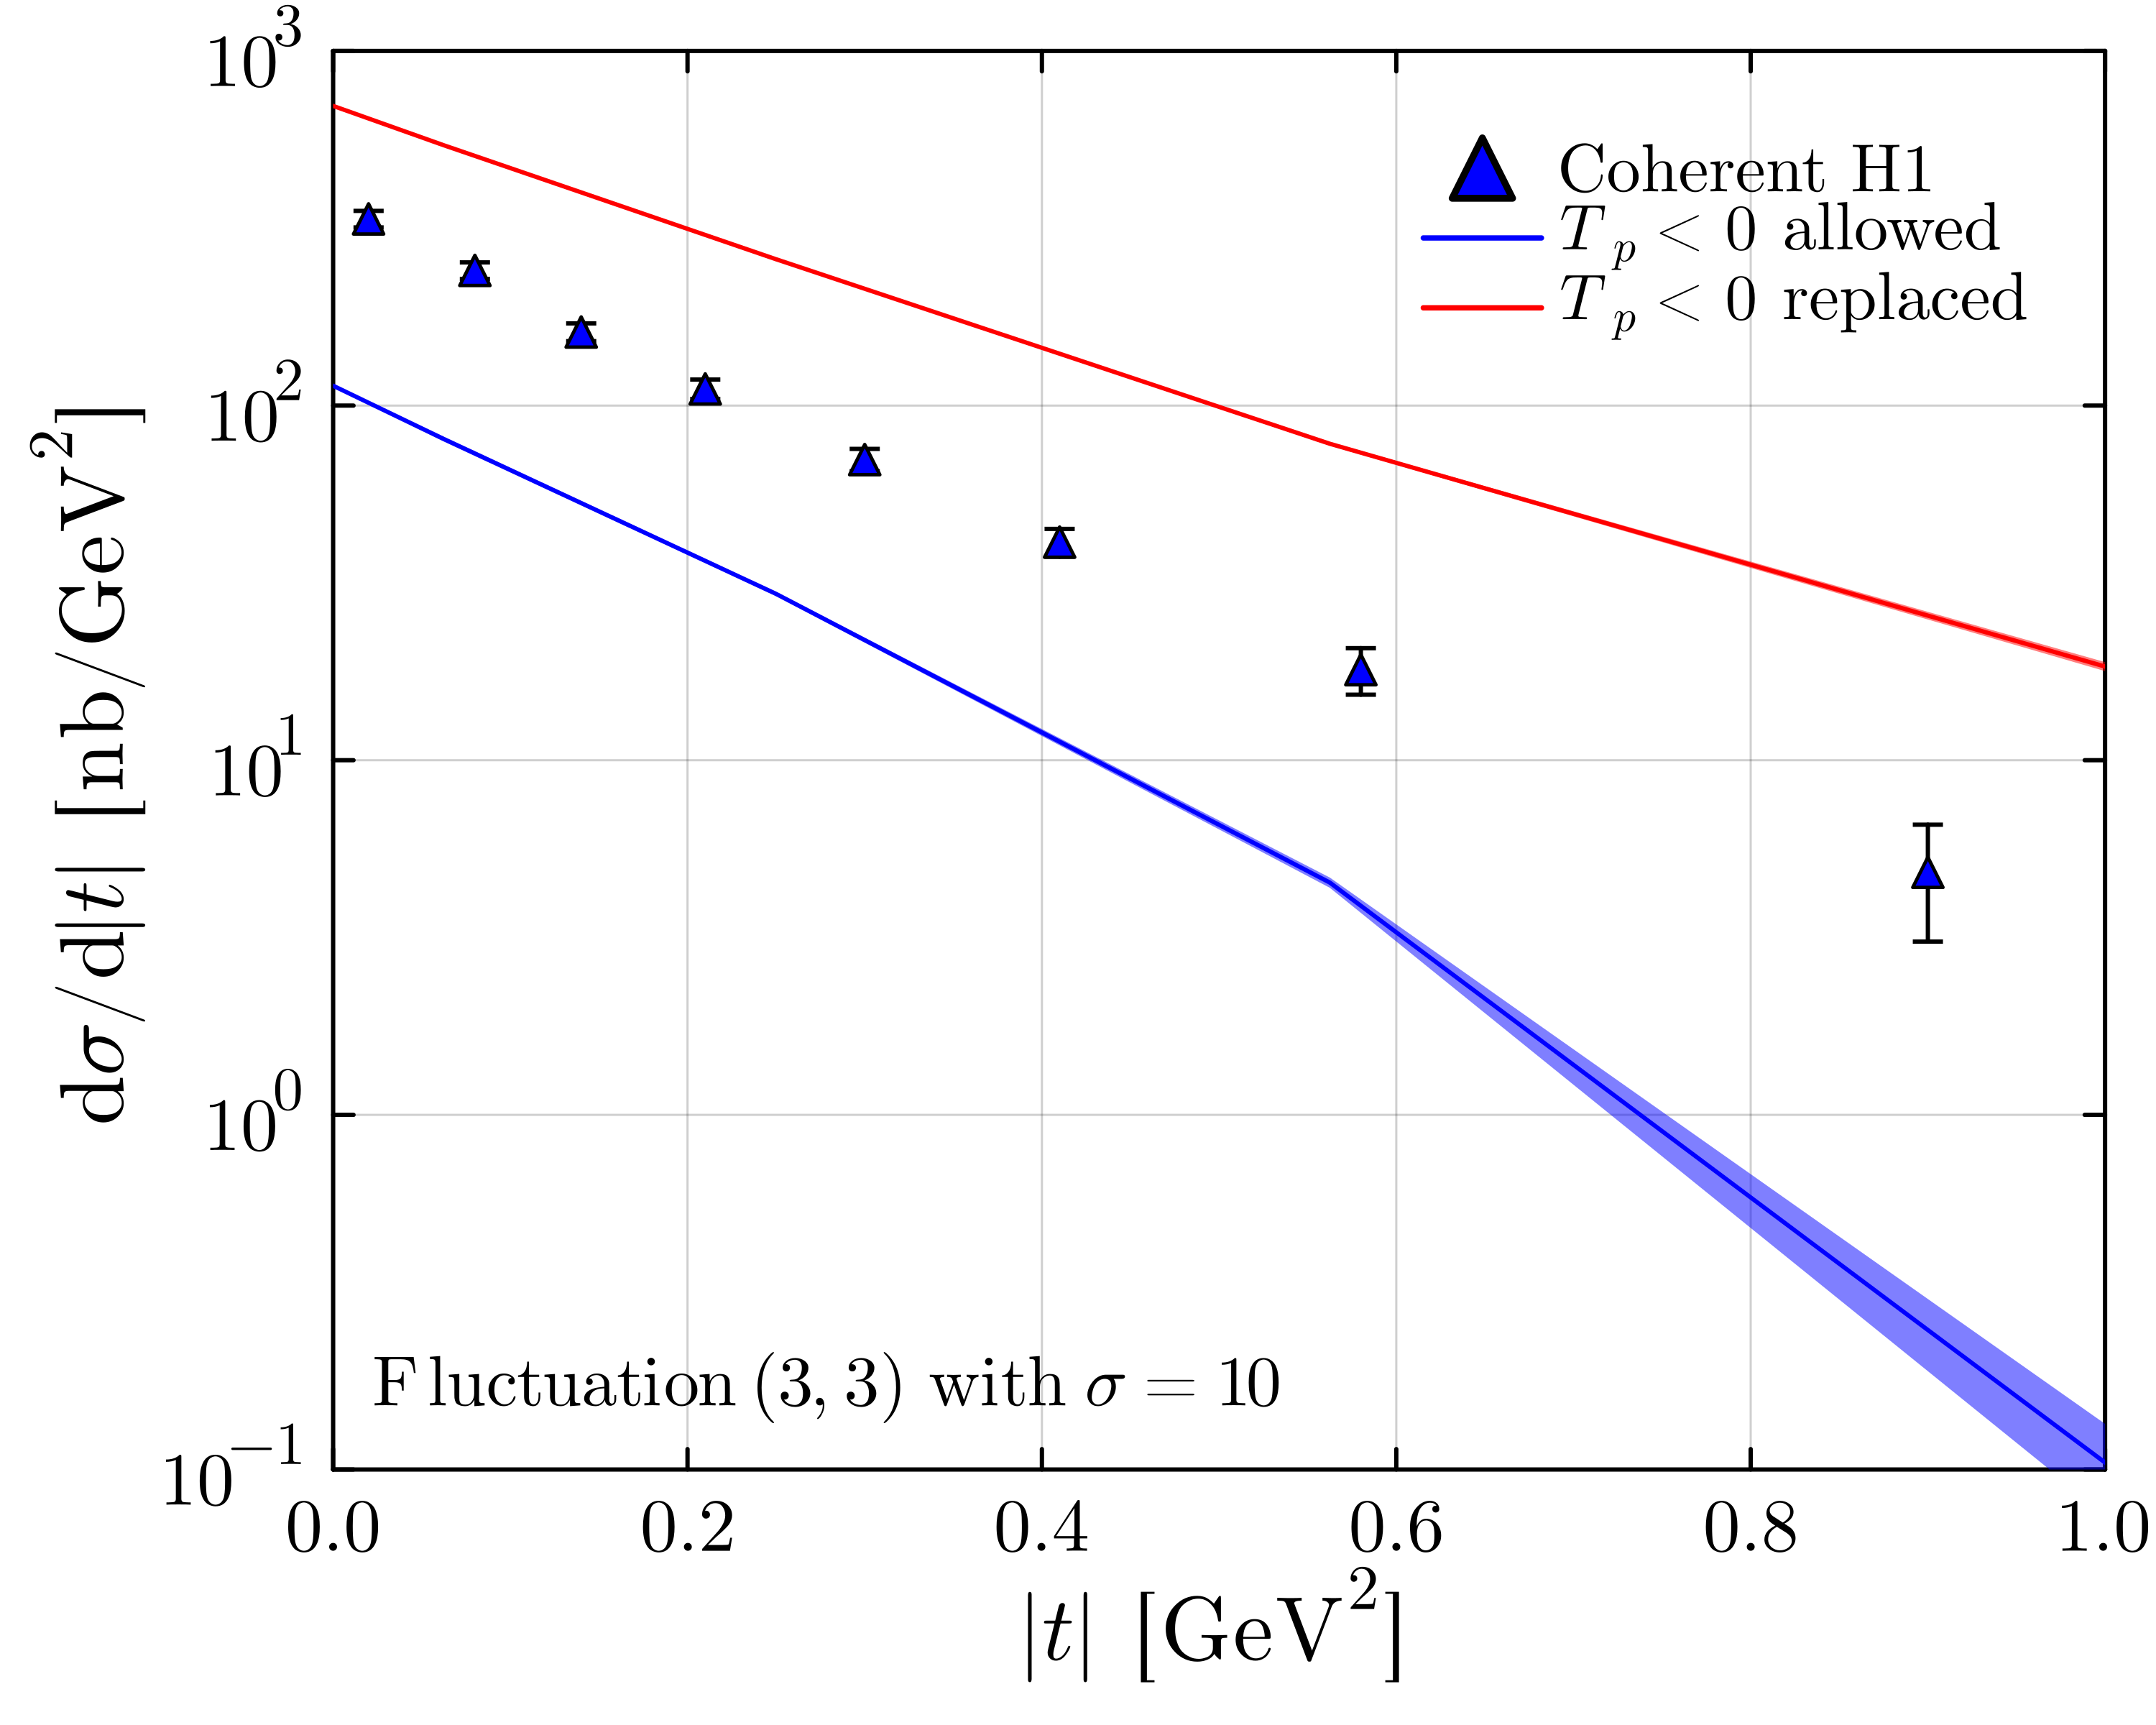

In [17]:
# data_notp = CohIncohMCData(t_range, dσdt_coh_notp, dσdt_coh_err_notp, dσdt_incoh_notp, dσdt_incoh_err_notp, tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera, tcent_incoh_hera, dσdt_incoh_hera, Δtot_incoh_hera)
data_notp = CoherentMCData(t_range, dσdt_coh_notp, dσdt_coh_err_notp, tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera)
data_tp = CoherentMCData(t_range, dσdt_coh_tp, dσdt_coh_err_tp, tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera)
p = plot(data_notp; custom_label = "\$T_p<0\$ allowed", color = :blue)
plot!(p, data_tp; custom_label = "\$T_p<0\$ replaced", color=:red, hera=false)
ylims!(p, (0.1, 1000))
annotate!(p, 0.28, 0.17, text(L"\mathrm{Fluctuation}~(3,3)~\mathrm{with}~\sigma=10", :black, 11))

In [18]:
savefig(p, "../plots/jpsi_coh_incoh_hera_sigma_10.0_negtp.png")

"/Users/dana/Work/protonshape/plots/jpsi_coh_incoh_hera_sigma_10.0_negtp.png"

---

#### Plot without $T_p<0$ 
Check if thickness function becomes negative, replace with $0$ when it does, vizualize.

In [1]:
import Pkg
Pkg.activate("/Users/dana/Work/protonshape")

  Activating project at `~/Work/protonshape`


In [2]:
include("../src/ProtonShape.jl")
using .ProtonShape

In [3]:
include("../src/plotrecipes.jl")

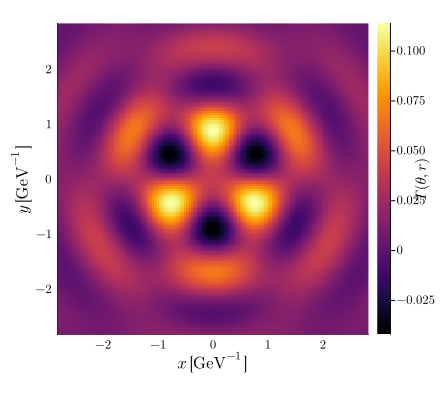

In [5]:
sg = SingleConfiguration(coeff_dict=Dict((3, 3) => 5.0), L=√8, Nx=128, Ny=128, func_type="Tp", a=√8, env_func=gaussenv, α=4, checktp=false)
sg = plot(sg)

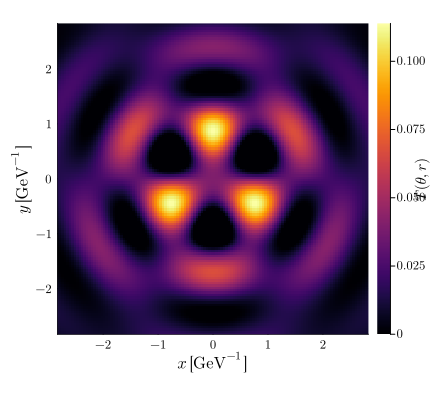

In [4]:
sg = SingleConfiguration(coeff_dict=Dict((3, 3) => 5.0), L=√8, Nx=128, Ny=128, func_type="Tp", a=√8, env_func=gaussenv, α=4, checktp=true)
sg = plot(sg)